In [8]:
import numpy as np
import awkward

import matplotlib

fig_width = 5
fig_height = 4
params = {
          #'backend': 'notebook',
          'text.latex.preamble': [r'\usepackage{gensymb}'],
          'axes.labelsize': 8, # fontsize for x and y labels (was 10)
          'axes.titlesize': 8,
          'font.size': 8, # was 10
          'text.usetex': False,
          'figure.figsize': [fig_width,fig_height],
          'font.family': 'serif'
}

matplotlib.rcParams.update(params)
    
import matplotlib.pyplot as plt
import itertools
import numpy as np
import numba

In [2]:
fn = "../data/2"

In [3]:
pts = np.memmap("{0}.Jet.pt.mmap".format(fn), dtype=np.float32)
etas = np.memmap("{0}.Jet.eta.mmap".format(fn), dtype=np.float32)
phis = np.memmap("{0}.Jet.phi.mmap".format(fn), dtype=np.float32)

offsets = np.memmap("{0}.Jet.offsets.mmap".format(fn), dtype=np.uint64)

In [20]:
pt_jag = awkward.JaggedArray.fromoffsets(np.array(offsets, dtype=np.int64), pts)
eta_jag = awkward.JaggedArray.fromoffsets(offsets, etas)
phi_jag = awkward.JaggedArray.fromoffsets(offsets, phis)

In [6]:
pt_jag.content

memmap([61.29351 , 39.545116, 28.863787, ..., 86.62336 , 80.02655 ,
        60.16085 ], dtype=float32)

In [7]:
pt_jag.offsets

memmap([       0,        4,       11, ..., 18039610, 18039617, 18039620],
       dtype=uint64)

In [11]:
def fill_matrix(jag, Nx, Ny):
    mat = np.zeros((Nx,Ny), dtype=np.float32)
    for i in range(mat.shape[0]):
        for j in range(min(jag.counts[i], mat.shape[1])):
            mat[i,j] = jag[i][j]
    return mat

In [21]:
Nev = 50
Njet = 20
mat_pt = fill_matrix(pt_jag, Nev, Njet)
mat_eta = fill_matrix(eta_jag, Nev, Njet)
mat_phi = fill_matrix(phi_jag, Nev, Njet)

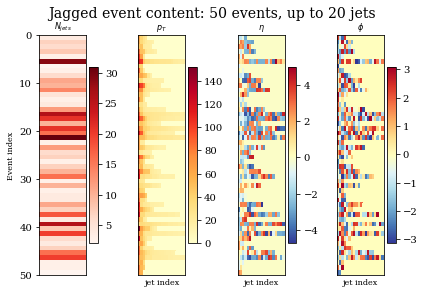

In [22]:
plt.figure(figsize=(6,4))
plt.suptitle("Jagged event content: {0} events, up to {1} jets".format(Nev, Njet), y=1.01, fontsize=14)

plt.subplot(1,4,1)
#plt.imshow(pt_jag.counts[:Nev].reshape(Nev,1), aspect=100.0 / Nev / Njet / 2, cmap="YlOrRd", interpolation="nearest")
plt.pcolormesh(pt_jag.counts[:Nev].reshape(Nev,1), cmap="Reds")
plt.gca().invert_yaxis()
plt.title("$N_{jets}$")
plt.ylabel("Event index")
plt.xticks([])
plt.colorbar()

plt.subplot(1,4,2)
#plt.imshow(mat_pt, cmap="YlOrRd", aspect="equal", interpolation="nearest")
plt.pcolormesh(mat_pt, cmap="YlOrRd")
plt.gca().invert_yaxis()
plt.xlabel("jet index")
plt.xticks([])
plt.yticks([])
plt.title("$p_T$")
plt.colorbar()

plt.subplot(1,4,3)
plt.pcolormesh(mat_eta, cmap="RdYlBu_r")
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel("jet index")
plt.title("$\eta$")
plt.colorbar()

plt.subplot(1,4,4)
#plt.imshow(mat_phi, cmap="RdYlBu_r", aspect="equal", interpolation="nearest")
plt.pcolormesh(mat_phi, cmap="RdYlBu_r")
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel("jet index")
plt.title("$\phi$")
plt.colorbar()

plt.tight_layout()
plt.savefig("/Users/joosep/Dropbox/caltech/hepaccelerate/jagged_matrices.pdf", bbox_inches="tight")

In [40]:
pt = pt_jag

In [41]:
def sumpt_event(data, offsets, ret):
    ret[:] = 0
    for iev in range(len(offsets)-1):
        i0 = offsets[iev]
        i1 = offsets[iev+1]
        for j in range(i0, i1):
            ret[iev] += data[j]
    return ret

sum1 = np.zeros(len(offsets)-1, dtype=np.float64)
%timeit sumpt_event(pt_jag.content, pt_jag.offsets, sum1)

1 loop, best of 3: 17.9 s per loop


In [47]:
%timeit -n3 pt_jag.sum()

3 loops, best of 3: 62.2 ms per loop


In [48]:
@numba.njit(parallel=True)
def sumpt_event(data, offsets, ret):
    ret[:] = 0
    for iev in range(len(offsets)-1):
        i0 = offsets[iev]
        i1 = offsets[iev+1]
        for j in range(i0, i1):
            ret[iev] += data[j]
    return ret

sum1 = np.zeros(len(offsets)-1, dtype=np.float64)
%timeit -n3 sumpt_event(pt_jag.content, pt_jag.offsets, sum1)

3 loops, best of 3: 32.6 ms per loop
